# Selfplay with Alpha-Beta search

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm import tqdm
import os
os.chdir('../selfplayAB/')
import sys
sys.path.append('../src')
from engine import BigBoard

In [2]:
results = []
first_moves = []
second_moves = []
len_games = []
final_boards = []

xxx = np.load('data.zip')
print(f'Got {len(xxx.files)} games')

pbar = tqdm()
for moves in xxx.values():
    results.append(moves[-1, 0].item())
    first_moves.append(moves[0])
    second_moves.append(moves[1])
    len_games.append(len(moves) - 1)
    
    a = BigBoard()
    for m in moves[:-1]:
        a.move(*m)
    final_boards.append(np.array(a.boards))
    
    pbar.update()

pbar.close()
results = np.array(results)
first_moves = np.array(first_moves)
final_boards = np.stack(final_boards)
final_boards = ((final_boards + 1) % 3) - 1

Got 10000 games


10000it [00:18, 545.14it/s]


In [3]:
data = pd.DataFrame(columns=['Games', 'X', 'O', 'T'])
for i in range(0, len(results), 5000):
    hist = np.histogram(results[i:i+5000], bins=[1,2,3,4], density=True)[0]
    data = data.append({'Games': f'{i//1000+5}k',
                        'X': hist[0],
                        'O': hist[1],
                        'T': hist[2],
                        }, ignore_index=True)
data = data.melt(id_vars='Games', var_name='Result', value_name='Percent')

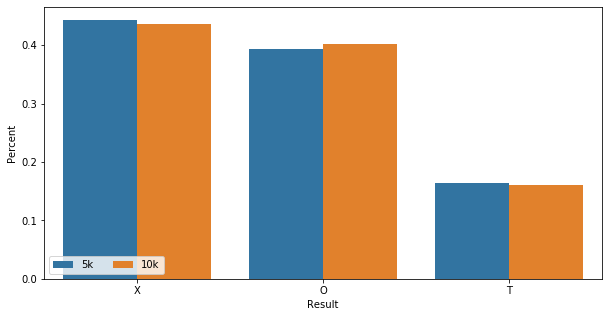

In [4]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Result', y='Percent', hue='Games', data=data, ci=None)
plt.legend(loc='lower left', ncol=3)
plt.show()

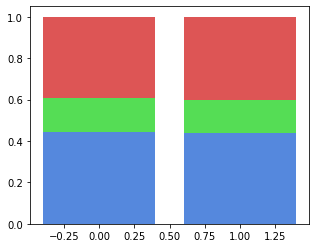

In [5]:
n = len(data) // 3
dat = data['Percent'].to_numpy()
plt.figure(figsize=(5, 4))
plt.bar(np.arange(n), dat[0:n]+dat[2*n:]+dat[n:2*n], color='#dd5555')
plt.bar(np.arange(n), dat[0:n]+dat[2*n:], color='#55dd55')
plt.bar(np.arange(n), dat[0:n], color='#5588dd')
plt.show()

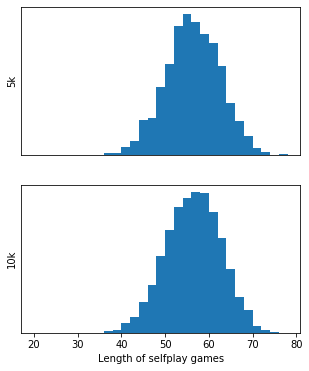

In [6]:
n = (len(results)+4999) // 5000
plt.subplots(figsize=(5, 6))
for i in range(n):
    plt.subplot(n, 1, i+1)
    plt.hist(len_games[5000*i:5000*(i+1)], bins=np.arange(20, 80, 2), density=True)
    plt.ylabel(f'{5*(i+1)}k')
    plt.yticks([])
    if i != n-1:
        plt.xticks([])
plt.xlabel('Length of selfplay games')
plt.show()

In [7]:
def plot_first_moves(first_moves):
    grid = np.zeros((9,9))
    for move in first_moves:
        grid[move[0], move[1]] += 1
    grid

    grid = torch.tensor(grid).view(3, 3, 3, 3)
    grid = torch.cat(grid.chunk(3, dim=0), dim=2)
    grid = torch.cat(grid.chunk(3, dim=1), dim=3)
    grid = grid.squeeze()
    
    plt.imshow(grid, vmin=0)
    # plt.colorbar()

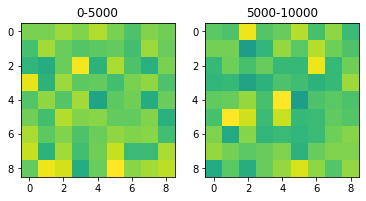

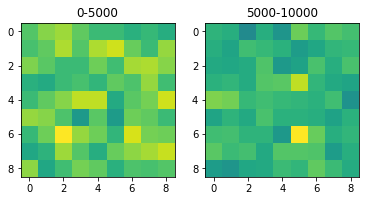

In [8]:
subplots = 5
ranges = [
    (   0, 5000),
    (5000, 10000),
]

plt.subplots(figsize=(16, 4))
for i, (a, b) in enumerate(ranges):
    plt.subplot(1, subplots, i+1)
    plot_first_moves(first_moves[a:b])
    plt.title(f'{a}-{b}')
plt.show()

plt.subplots(figsize=(16, 4))
for i, (a, b) in enumerate(ranges):
    plt.subplot(1, subplots, i+1)
    plot_first_moves(second_moves[a:b])
    plt.title(f'{a}-{b}')
plt.show()

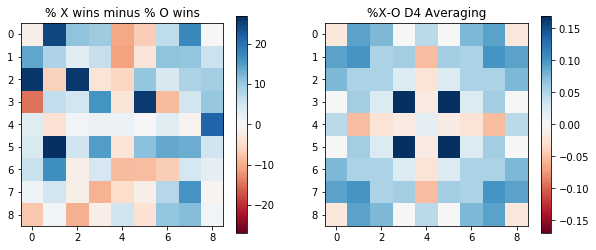

In [9]:
grid = np.zeros((9,9))
gridX = np.zeros((9,9))
gridO = np.zeros((9,9))
for move, r in zip(first_moves, results):
    grid[move[0], move[1]] += 1
    if r == 1:
        gridX[move[0], move[1]] += 1
    elif r == 2:
        gridO[move[0], move[1]] += 1
        
grid2 = (gridX - gridO) / grid
grid2 = torch.tensor(grid2).view(3, 3, 3, 3)
grid2 = torch.cat(grid2.chunk(3, dim=0), dim=2)
grid2 = torch.cat(grid2.chunk(3, dim=1), dim=3)
grid2 = grid2.squeeze()
grid2 *= 100

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(grid2, 
           vmin=-grid2.abs().max(), 
           vmax=grid2.abs().max(),
           cmap='RdBu')
plt.colorbar()
plt.title('% X wins minus % O wins')

##########
       
gridX = torch.tensor(gridX).view(3, 3, 3, 3)
gridX = torch.cat(gridX.chunk(3, dim=0), dim=2)
gridX = torch.cat(gridX.chunk(3, dim=1), dim=3)
gridX = gridX.squeeze()

gridO = torch.tensor(gridO).view(3, 3, 3, 3)
gridO = torch.cat(gridO.chunk(3, dim=0), dim=2)
gridO = torch.cat(gridO.chunk(3, dim=1), dim=3)
gridO = gridO.squeeze()

grid = torch.tensor(grid).view(3, 3, 3, 3)
grid = torch.cat(grid.chunk(3, dim=0), dim=2)
grid = torch.cat(grid.chunk(3, dim=1), dim=3)
grid = grid.squeeze()

gridX = gridX + gridX.transpose(0, 1)
gridX = gridX + gridX.flip(0)
gridX = gridX + gridX.flip(1)
gridX /= 8

gridO = gridO + gridO.transpose(0, 1)
gridO = gridO + gridO.flip(0)
gridO = gridO + gridO.flip(1)
gridO /= 8

grid = grid + grid.transpose(0, 1)
grid = grid + grid.flip(0)
grid = grid + grid.flip(1)
grid /= 8

grid = (gridX - gridO) / grid

plt.subplot(122)
plt.imshow(grid, 
           vmin=-grid.abs().max(), 
           vmax=grid.abs().max(),
           cmap='RdBu')
plt.colorbar()
plt.title('%X-O D4 Averaging')
plt.show()

In [10]:
def plot_board(board, symmetric=True, scale_down=False):
    grid = torch.tensor(board).view(3, 3, 3, 3).float()
    grid = torch.cat(grid.chunk(3, dim=0), dim=2)
    grid = torch.cat(grid.chunk(3, dim=1), dim=3)
    grid = grid.squeeze()
    
    if symmetric:
        grid = grid + grid.transpose(0, 1)
        grid = grid + grid.flip(0)
        grid = grid + grid.flip(1)
        grid /= 8

    if scale_down:
        grid /= 1.5
    else:
        grid *= 1.5

    plt.imshow(grid, vmin=-1, vmax=1, cmap='RdBu')

# plot_board(np.mean(final_boards, axis=0))

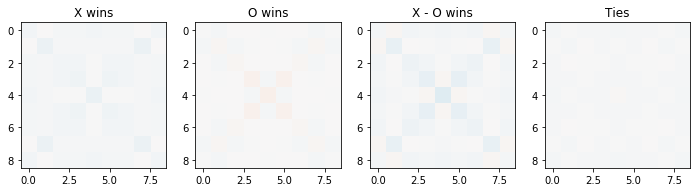

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(141)
plot_board(np.mean(final_boards[results[-len(final_boards):] == 1], axis=0))
plt.title('X wins')
plt.subplot(142)
plot_board(np.mean(final_boards[results[-len(final_boards):] == 2], axis=0))
plt.title('O wins')
plt.subplot(143)
plot_board(np.mean(final_boards[results[-len(final_boards):] == 1], axis=0) - \
           np.mean(final_boards[results[-len(final_boards):] == 2], axis=0))
plt.title('X - O wins')
plt.subplot(144)
plot_board(np.mean(final_boards[results[-len(final_boards):] == 3], axis=0))
plt.title('Ties')
plt.show()

## Extra

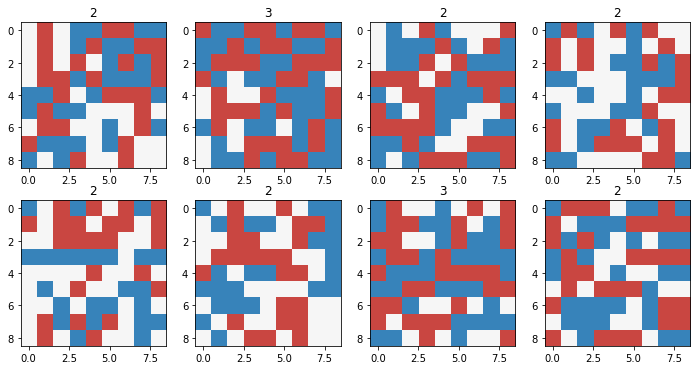

In [25]:
plt.subplots(figsize=(12, 6))
for i in range(1, 9):
    plt.subplot(2, 4, i)
    plot_board(final_boards[-i], symmetric=False, scale_down=True)
    plt.title(results[-i])
plt.show()

In [27]:
# Cannot allocate len x len x 9 x 9 array to do simultaneous comparisons
duplicates = np.ones((len(final_boards), len(final_boards)), dtype=bool)
for i in tqdm(range(len(final_boards) - 1)):
    j = i + 1
    diff = np.count_nonzero(np.abs(final_boards[j:] - final_boards[i]), axis=(1, 2))
    duplicates[i, j:] = diff.astype(bool)

100%|█████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:36<00:00, 272.38it/s]


In [28]:
x, y = np.where(duplicates == False)
duplicates = np.stack([x, y]).T
duplicates

array([], shape=(0, 2), dtype=int64)

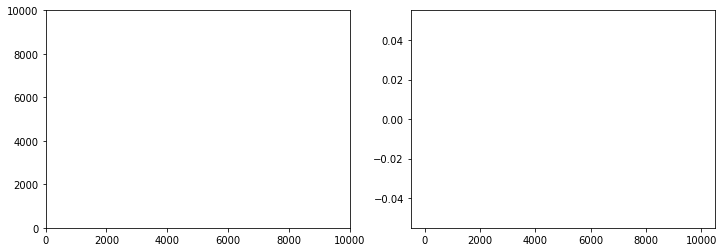

In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(x, y, '.')
plt.xlim([0, len(results)])
plt.ylim([0, len(results)])
plt.subplot(122)
plt.hist(x, bins=list(range(0, len(results)+1000, 1000)))
plt.show()